In [2]:
import pandana as pdna
import pandas as pd
import geopandas as gpd

import matplotlib
from matplotlib import pyplot as plt
import h3

Before running this notebook, first create the walk and bike network using the notebook save_osm_networks.ipynb

# Create the Pandana network(s)

In [3]:
networks={}
for mode in ['walk', 'bike']:
    print(mode)
    nodes=pd.read_csv('./outputs/networks/{}_nodes.csv'.format(mode), index_col=0)
    edges=pd.read_csv('./outputs/networks/{}_edges.csv'.format(mode), index_col=0)
    net = pdna.Network(nodes["x"],
                   nodes["y"],
                   edges["from"],
                   edges["to"],
                   edges[["weight"]], 
                   twoway=False)
    net.nodes_df['h3']=net.nodes_df.apply(lambda row: h3.geo_to_h3(lat=row['y'], lng=row['x'], 
                                                     resolution=10), axis=1)
    networks[mode]=net

walk
bike


# Get the POI Data

## Get Lat and Long from Addresses


In [4]:
from geopy.geocoders import Nominatim
# can be improved, as the latitude and longitude do not consider the address number
geolocator = Nominatim(user_agent="CS-Rome")

def extract_lat_long_from_address(df, address_col, address_suffix):
    df['latitude'] = ""
    df['longitude'] = ""
    for index,row in df.iterrows():
        address = row[address_col]
        try:
            location = geolocator.geocode(address + address_suffix)
            df.loc[index,['latitude']] = location.latitude
            df.loc[index,['longitude']] = location.longitude
        except:
            print('Error while managing address: ', address)

## Create POI file

In [5]:
def create_poi_file(df, lat_col_name, lon_col_name, name_col, data_source, notes_col_name, filename):
    df_poi = pd.DataFrame(columns = ["name", "lat", "long", "data source"])
    df_poi[["name", "lat", "long", "notes"]] = df[[name_col, lat_col_name, lon_col_name, notes_col_name]]
    df_poi["data source"] = data_source
    df_poi.to_csv("dataset/poi/"+filename+".csv", sep=";", index=False)

In [6]:
DATA_PATH="Dataset-Dropbox/"

## Public transport stops
source: https://dati.comune.roma.it/

In [9]:
transport_stops=pd.read_csv(DATA_PATH+'02-PublicTransports/'+'stops.txt', sep=',')
transport_stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,stop_url,wheelchair_boarding,stop_timezone,location_type,parent_station
0,73068,73068,AURELIA/GIORGIERI,NaN,41.885057,12.390125,NaN,NaN,NaN,NaN,NaN
1,73089,73089,AURELIA/PIRONTI,NaN,41.892847,12.414483,NaN,NaN,NaN,NaN,NaN
2,73160,73160,AURELIA/RICHELMY,NaN,41.898517,12.442255,NaN,NaN,NaN,NaN,NaN
3,73063,73063,AURELIA/RICHELMY,NaN,41.898627,12.441728,NaN,NaN,NaN,NaN,NaN
4,75524,75524,AVANZINI/QUARTIERE INCIS,NaN,41.866590,12.410422,NaN,NaN,NaN,NaN,NaN


In [11]:
create_poi_file(df=transport_stops, lat_col_name="stop_lat", lon_col_name="stop_lon", name_col="stop_name", data_source="Open Data Roma", notes_col_name="stop_id", filename="PublicTransportStops")

## Municipal Sport Centers
source: https://dati.comune.roma.it/

In [65]:
SPORTS_DATA_LOC='https://dati.comune.roma.it/catalog/dataset/acb9bbf0-9beb-409d-b5e8-b4407dec1aef/resource/809dfc0d-f305-4b9e-a487-2b4ce7fd5b0c/download/centri_sportivi_municipali_2018.csv'

In [13]:
sports_centers=pd.read_csv(DATA_PATH+'04-SportsVenues/'+'centri_sportivi_municipali_2018.csv', sep=';',encoding = "latin")

In [14]:
sports_centers

,ID,MUNICIPIO,ISTITUTO COMPRENSIVO,CENTRO SPORTIVO MUNICIPALE,INDIRIZZO,LARGHEZZA,LUNGHEZZA,ALTEZZA,SPOGLIATOI,STATO MANUTENTIVO,NOTE
0,1,I,I.C. Via delle Carine,Plesso Mazzini,"Via delle Carine, 2",9,"14,2",5,si,discreto,NaN
1,2,I,I.C. Regina Elena,Plesso R. Elena,"Via Puglie, 6",9,18,6,si,discreto,NaN
2,3,I,I.C. Regina Elena,Plesso Pestalozzi,"Via Montebello, 118","9,5","10,5",6,no,mediocre,NaN
3,4,I,I.C. Virgilio,Plesso Cadlolo,"Via della Rondinella, 2",9,20,7,no,discreto,NaN
4,5,I,I.C. Dante Alighieri,Plesso Cassiodoro,"Via Cassiodoro, 2B",12,"23,7",7,si,ottimo,NaN
...,...,...,...,...,...,...,...,...,...,...,...
357,358,XV,NaN,Enzo Biagi - Angelini - M. Periello,"Via Quero, 130","10,5","20,7",NaN,si,buono,NaN
358,359,XV,NaN,Karol Wojtyla - Sede centrale,"Via Concesio, 2","11,5","23,85",6,si,discreto,NaN
359,360,XV,NaN,Karol Wojtyla - Plesso,"Largo Giampaolo Borghi, 6","12,3","24,55",NaN,si,discreto,NaN
360,361,XV,NaN,Parco di Veio - Sede Centrale,Via Fosso del Fontaniletto,"11,1","22,45",6,si,buono,NaN


In [15]:
sports_centers["INDIRIZZO"]=sports_centers["INDIRIZZO"].apply(str)
# Fixing addresses withouth address number
for index,row in sports_centers.iterrows():
    if ', SNC' in row['INDIRIZZO']:
        sports_centers.loc[index,['INDIRIZZO']] = row['INDIRIZZO'].replace(', SNC', ', 1')

In [16]:
extract_lat_long_from_address(sports_centers, address_col="INDIRIZZO", address_suffix=", Roma, Roma Capitale, Lazio, Italia")

Error while managing address:  P.le deglie Eroi, 14
Error while managing address:  Via S.M. Goretti, 43
Error while managing address:  Piazza Ruggero da Sicilia, 2
Error while managing address:  Via R. Calabria, 48
Error while managing address:  Via G. da Procida, 16 
Error while managing address:  Via G. da Procida, 16 
Error while managing address:  Via J. Pintor, 6
Error while managing address:  Via Don G. M. Mussolillo, 64
Error while managing address:  Via F. andò, 15
Error while managing address:  Via Antonio Serassi,75
Error while managing address:  Via V. mezzogiorno, 20
Error while managing address:  Via Scalo di Settebagni, 45
Error while managing address:  Via Scalo di Settebagni, 45
Error while managing address:  Via G. De Santis, 27
Error while managing address:  Via C. Angiolieri, 15
Error while managing address:  Via Saffiano, 34
Error while managing address:  Via M. Baldo, 2
Error while managing address:  Via Casal Bianco, 140
Error while managing address:  Via N.M. Nic

In [17]:
#removing rows withouth coordinates
sports_centers.replace("", float("NaN"), inplace=True)
sports_centers["latitude"]=sports_centers["latitude"].apply(float)
sports_centers["longitude"]=sports_centers["longitude"].apply(float)
sports_centers.dropna(subset = ["latitude", "longitude"], inplace=True)

In [18]:
sports_centers.head()

,ID,MUNICIPIO,ISTITUTO COMPRENSIVO,CENTRO SPORTIVO MUNICIPALE,INDIRIZZO,LARGHEZZA,LUNGHEZZA,ALTEZZA,SPOGLIATOI,STATO MANUTENTIVO,NOTE,latitude,longitude
0,1,I,I.C. Via delle Carine,Plesso Mazzini,"Via delle Carine, 2",9,"14,2",5,si,discreto,NaN,41.892553,12.490998
1,2,I,I.C. Regina Elena,Plesso R. Elena,"Via Puglie, 6",9,18,6,si,discreto,NaN,41.909715,12.495423
2,3,I,I.C. Regina Elena,Plesso Pestalozzi,"Via Montebello, 118","9,5","10,5",6,no,mediocre,NaN,42.094373,12.910528
3,4,I,I.C. Virgilio,Plesso Cadlolo,"Via della Rondinella, 2",9,20,7,no,discreto,NaN,41.901138,12.468548
4,5,I,I.C. Dante Alighieri,Plesso Cassiodoro,"Via Cassiodoro, 2B",12,"23,7",7,si,ottimo,NaN,41.906183,12.465886


In [19]:
sports_centers.groupby('MUNICIPIO').size()

MUNICIPIO
I       11
II      10
III     25
IV      13
IX       3
V       28
VI      39
VIII    11
XI      10
XII     11
XIII    14
XIV     17
XV      26
dtype: int64

In [20]:
sports_centers.groupby('STATO MANUTENTIVO').size()

STATO MANUTENTIVO
buone                                            1
buono                                           46
buonoo                                           1
cattivo                                          4
discreto                                        28
idoneo all'affidamento                          25
idoneo per attività sportive                    38
inagibile per lavori in corso alle strutture     1
mediocre                                        17
necessita manutenzione                           1
necessità interventi                             1
ottimo                                           3
palestra in ristrutturazione                     1
pavimentazione necessità manutenzione            1
pessimo                                          2
pessimo, non agibile                             1
sufficiente                                      2
dtype: int64

In [21]:
create_poi_file(df=sports_centers, lat_col_name="latitude", lon_col_name="longitude", name_col="ISTITUTO COMPRENSIVO", data_source="Open Data Roma", notes_col_name="CENTRO SPORTIVO MUNICIPALE", filename="SportsCenters")

# Public Libraries
source: https://dati.comune.roma.it/

In [24]:
libs = pd.read_excel(DATA_PATH+'05-CulturalCenters/'+'DATI_BIBLIOTECHE_EXCEL_01.xls', sheet_name='Report personalizzato')  
libs.head()

,biblioteca,codice biblioteca,sigla provincia,provincia,CAP,città,indirizzo,cod. paese,paese,email,telefono
0,B. COSTANZO LICEO GIULIO CESARE,RMBWG,RM,ROMA,198.0,ROMA,Corso Trieste 48,IT,ITALIA,NaN,NaN
1,BIBLIOBUS,RMBX1,NaN,NaN,NaN,ROMA,.,IT,ITALIA,ill.bibliobus@bibliotechediroma.it,NaN
2,BIBLIOCAFFE' LETTERARIO,RMBM1,RM,ROMA,NaN,ROMA,VIA OSTIENSE 95,IT,ITALIA,ill.bibliocaffe@bibliotechediroma.it,0645460710
3,BIBLIOTECA ALDO FABRIZI,RMBE2,RM,ROMA,156.0,ROMA,Via Treia 14,IT,ITALIA,ill.aldofabrizi@bibliotechediroma.it,0645460730
4,BIBLIOTECA ARGENTINA,RMBWC,RM,ROMA,187.0,ROMA,"Via Vittorio Veneto, 7 - 2° piano",IT,ITALIA,biblioteca@ambasciatargentina.it,064873866


In [25]:
extract_lat_long_from_address(libs, address_col="indirizzo", address_suffix=", Roma, Italia")

Error while managing address:  Via Vittorio Veneto, 7  -  2° piano
Error while managing address:  VIA LIBERO LEONARDO 153
Error while managing address:  VIA SAN PAOLO ALLA REGOLA, 16
Error while managing address:  VIA COLLI PORTUENSI, 275
Error while managing address:  via delle Galline Bianche
Error while managing address:  VIA LONGHENA 98
Error while managing address:  via Penazzato, 112
Error while managing address:  Viale Caduti per la Resistenza 410/A
Error while managing address:  Via M. Mazzacurati 76
Error while managing address:  LARGO III GIUGNO 1849 SNC
Error while managing address:  Via Bompietro SNC
Error while managing address:  Magazzino centrale
Error while managing address:  PALAZZO ESPOSIZIONI - VIA NAZIONALE 194


In [26]:
#removing rows withouth coordinates
libs.replace("", float("NaN"), inplace=True)
libs["latitude"]=libs["latitude"].apply(float)
libs["longitude"]=libs["longitude"].apply(float)
libs.dropna(subset = ["latitude", "longitude"], inplace=True)

In [27]:
create_poi_file(df=libs, lat_col_name="latitude", lon_col_name="longitude", name_col="biblioteca", data_source="Open Data Roma", notes_col_name="codice biblioteca", filename="biblioteche")

## Primary Schools
source: https://dati.comune.roma.it/

In [28]:
schools=pd.read_csv(DATA_PATH+'03-Kindergartens/'+'02-infanzia_09-10.csv', sep=';',encoding = "latin")
schools = schools.dropna()

In [29]:
schools.head()

,Municipio,Codice scuola,Nome scuola,Indirizzo,Telefono,Orario entrata/uscita,Corsi attivi,Totale capienza,Totale iscritti,Iscritti maschi,Iscritti femmine,Iscritti italiani,Iscritti non italiani
0,I,3557.0,A. BACCARINI,"Via Sforza, 2",06/4883788,08:00 / 17:00,3.0,75.0,65.0,35.0,30.0,58.0,7.0
1,I,3549.0,A. CADLOLO,"Via Della Rondinella, 2",06/68802521,08:00 / 17:00,4.0,100.0,93.0,48.0,45.0,87.0,6.0
2,I,2886.0,ADELAIDE CAIROLI,"Via Giordano Bruno, 2",06/39738646,08:00 / 17:00,9.0,217.0,207.0,93.0,114.0,171.0,36.0
3,I,3553.0,E.GIANTURCO,"Via Della Palombella, 4",06/68307753,08:00 / 17:00,3.0,63.0,55.0,32.0,23.0,53.0,2.0
4,I,3556.0,E.PESTALOZZI,"Via Mentana, 1",06/4941465,08:00 / 17:00,2.0,50.0,36.0,18.0,18.0,30.0,6.0


In [30]:
schools.groupby('Municipio').size()

Municipio
I       22
II      15
III     13
IV      26
IX      26
V       19
VI      13
VII     32
VIII    18
X       10
XI      16
XII     11
XIII    17
XIV     14
XV      15
dtype: int64

In [31]:
# Fixing addresses withouth address number
for index,row in schools.iterrows():
    if ', SNC' in row['Indirizzo']:
        schools.loc[index,['Indirizzo']] = row['Indirizzo'].replace(', SNC', ', 1')

In [32]:
extract_lat_long_from_address(schools, address_col="Indirizzo", address_suffix=", Roma, Italia")

In [33]:
schools.head()

,Municipio,Codice scuola,Nome scuola,Indirizzo,Telefono,Orario entrata/uscita,Corsi attivi,Totale capienza,Totale iscritti,Iscritti maschi,Iscritti femmine,Iscritti italiani,Iscritti non italiani,latitude,longitude
0,I,3557.0,A. BACCARINI,"Via Sforza, 2",06/4883788,08:00 / 17:00,3.0,75.0,65.0,35.0,30.0,58.0,7.0,41.895706,12.495319
1,I,3549.0,A. CADLOLO,"Via Della Rondinella, 2",06/68802521,08:00 / 17:00,4.0,100.0,93.0,48.0,45.0,87.0,6.0,41.901138,12.468548
2,I,2886.0,ADELAIDE CAIROLI,"Via Giordano Bruno, 2",06/39738646,08:00 / 17:00,9.0,217.0,207.0,93.0,114.0,171.0,36.0,41.910303,12.452961
3,I,3553.0,E.GIANTURCO,"Via Della Palombella, 4",06/68307753,08:00 / 17:00,3.0,63.0,55.0,32.0,23.0,53.0,2.0,41.898189,12.476522
4,I,3556.0,E.PESTALOZZI,"Via Mentana, 1",06/4941465,08:00 / 17:00,2.0,50.0,36.0,18.0,18.0,30.0,6.0,41.806951,12.681261


## 

In [34]:
create_poi_file(df=schools, lat_col_name="latitude", lon_col_name="longitude", name_col="Nome scuola", data_source="Open Data Roma", notes_col_name="Codice scuola", filename="PrimarySchools")

## Cultural Centers
source: Open Street Map

In [36]:
cultural_centers=pd.read_csv(DATA_PATH+'05-CulturalCenters/'+'shape/cultural_centers.csv', sep=',',encoding = "latin")
cultural_centers = cultural_centers[cultural_centers['lat'].notna()]

cultural_centers.head()

,Unnamed: 0,Unnamed: 1,amenity,lat,lng,geometry,name,nodes
0,node,248517016,theatre,41.934920,12.567555,POINT (12.5675548 41.9349199),Di Via Speroni,NaN
1,node,248663946,cinema,41.887409,12.533910,POINT (12.5339105 41.8874086),Cineclub Alphaville,NaN
2,node,248674890,cinema,41.884219,12.472672,POINT (12.4726722 41.8842185),Nuovo Sacher,NaN
3,node,248676601,cinema,41.889320,12.474378,POINT (12.4743782 41.8893204),Reale,NaN
4,node,250884088,cinema,41.833877,12.468472,POINT (12.4684719 41.8338771),EUR Cine,NaN


In [37]:
create_poi_file(df=cultural_centers, lat_col_name="lat", lon_col_name="lng", name_col="name", data_source="OSM", notes_col_name="amenity", filename="CulturalCenters")

## Green Areas
source: Open Street Map

In [43]:
green=pd.read_csv(DATA_PATH+'01-GreenAreas/'+'shape/GreenAreas.csv', sep=',',encoding = "latin")
green = green[green['lat'].notna()]
green

C:\Users\ANTONE~1\AppData\Local\Temp/ipykernel_25876/971235243.py:1: DtypeWarning: Columns (2,3,4,5,8,9,11,12,13,14,17,19,21,22,27,29,30,31,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,59,60,61,62,63,64,65,66,67,71,72,75,76,78,79,82,83,86,87,88,89,90,91,92,93,94,95,97,98,99,100,101,102,103,104,105,106,107,108,109,110,112,113,114,115,116,117,118,119,120,121,122,123,125,128,129,130,136,137,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,165,166,167,168,169,170,172,173,174,175,176,177,178,180,182,183,184,185,186,187,188,189,190,191,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,223,224,225,226,227,228,229,230,301,305,306,307,308,309,310,311,312) have mixed types. Specify dtype option on import or set low_memory=False.
  green=pd.read_csv(DATA_PATH+'01-GreenAreas/'+'shape/GreenAreas.csv', sep=',',encoding = "latin")


,Unnamed: 0,Unnamed: 1,amenity,name,name:ru,public_transport,geometry,ele,name:fr,name:it,...,cuisine,restaurant:type:it,wikipedia:he,charge,owner,payment:mastercard,payment:visa,assembly_point:earthquake,lat,lng
0,node,259627564,NaN,NaN,NaN,NaN,POINT (12.4812329 41.928485),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.928485,12.481233
1,node,259647197,NaN,Monte Mario,NaN,NaN,POINT (12.4521318 41.9244045),139.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.924405,12.452132
2,node,339526176,NaN,NaN,NaN,NaN,POINT (12.4742713 41.8822255),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.882225,12.474271
3,node,417242101,NaN,NaN,NaN,NaN,POINT (12.5211922 41.8694746),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.869475,12.521192
4,node,427838899,NaN,NaN,NaN,NaN,POINT (12.4856412 41.8128115),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.812812,12.485641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31862,way,13649,NaN,NaN,NaN,NaN,"LINESTRING (12.3315163 42.0233979, 12.3326562 ...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.023354,12.332086
31863,way,13651,NaN,NaN,NaN,NaN,"POLYGON ((12.3480053 41.7678951, 12.3483025 41...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.767802,12.348232
31864,way,13652,NaN,NaN,NaN,NaN,"POLYGON ((12.5562685 41.9623832, 12.5564348 41...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.962187,12.556370
31865,way,13653,NaN,NaN,NaN,NaN,"POLYGON ((12.4749193 41.8534152, 12.4748415 41...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.853370,12.474557


In [44]:
create_poi_file(df=green, lat_col_name="lat", lon_col_name="lng", name_col="name", data_source="OSM", notes_col_name="amenity", filename="GreenAreas")

## Historical
source: Open Street Map

In [46]:
historical=pd.read_csv(DATA_PATH+'05-CulturalCenters/'+'shape/historical.csv', sep=',',encoding = "latin")
#historical = historical.dropna()
historical = historical[historical['lat'].notna()]
historical

,Unnamed: 0,Unnamed: 1,geometry,lat,lng,historic,nodes,name
0,node,248743131,POINT (12.4797478 41.9107979),41.910798,12.479748,memorial,NaN,Obelisco di Antinoo
1,node,256170032,POINT (12.5017974 41.8731861),41.873186,12.501797,sarcophagus,NaN,NaN
2,node,256753107,POINT (12.5037397 41.8955021),41.895502,12.503740,ruins,NaN,Porta Magica
3,node,257751157,POINT (12.5095558 41.8988072),41.898807,12.509556,city_gate,NaN,NaN
4,node,257751159,POINT (12.509602 41.8987395),41.898739,12.509602,city_gate,NaN,NaN
...,...,...,...,...,...,...,...,...
1531,way,972,"POLYGON ((12.5431823 41.8319317, 12.5431762 41...",41.831926,12.543178,ruins,"[9487918263, 9487918264, 9487918265, 948791826...",NaN
1532,way,973,"POLYGON ((12.5430865 41.832013, 12.5430974 41....",41.832004,12.543090,ruins,"[9487918271, 9487918272, 9487918273, 948791827...",NaN
1533,way,974,"POLYGON ((12.5431277 41.8319885, 12.5431434 41...",41.831977,12.543128,ruins,"[9487918278, 9487918279, 9487918280, 948791828...",NaN
1534,way,975,"POLYGON ((12.5429123 41.8321697, 12.5429274 41...",41.832161,12.542918,ruins,"[9487918282, 9487918283, 9487918284, 948791828...",NaN


In [47]:
create_poi_file(df=historical, lat_col_name="lat", lon_col_name="lng", name_col="name", data_source="OSM", notes_col_name="historic", filename="Historical")

## Museums
source: Open Street Map

In [48]:
museums=pd.read_csv(DATA_PATH+'05-CulturalCenters/'+'shape/museums.csv', sep=',',encoding = "latin")
museums = museums[museums['lat'].notna()]
museums

,Unnamed: 0,Unnamed: 1,geometry,lat,lng,tourism,name,website,wikidata,addr:street
0,node,401949920,POINT (12.478044 41.8320562),41.832056,12.478044,museum,Museo della CiviltÃ Romana,http://www.museociviltaromana.it/,Q1275123,Piazza Giovanni Agnelli
1,node,401949921,POINT (12.4774786 41.8309111),41.830911,12.477479,museum,Museo dell'Astronomia e Planetario,http://www.planetarioroma.it/,NaN,NaN
2,node,602095458,POINT (12.5010785 41.909267),41.909267,12.501079,museum,Museo Storico dei Bersaglieri,NaN,Q603939,NaN
3,node,656532697,POINT (12.4722011 41.8938866),41.893887,12.472201,museum,Galleria Spada,http://galleriaspada.beniculturali.it/index.ph...,Q3757699,Piazza Capo di Ferro
4,node,656829698,POINT (12.4727772 41.8972775),41.897278,12.472777,museum,Museo di Roma,http://www.museodiroma.it/,Q3868175,Via di San Pantaleo
...,...,...,...,...,...,...,...,...,...,...
125,way,35,"POLYGON ((12.5636648 41.928477, 12.5635862 41....",41.928341,12.563816,museum,Museo di Casal de' Pazzi,http://www.museocasaldepazzi.it/,Q3868167,Viale Egidio Galbani
126,way,37,"POLYGON ((12.515989 41.9026058, 12.5159639 41....",41.902521,12.516098,museum,Etruscan and Italic Antiquities Museum,NaN,NaN,NaN
127,way,38,"POLYGON ((12.5162362 41.9023734, 12.5162719 41...",41.902260,12.516119,museum,Museum of Origins,NaN,NaN,NaN
128,way,39,"POLYGON ((12.515989 41.9026058, 12.5159639 41....",41.902521,12.516098,museum,Etruscan and Italic Antiquities Museum,NaN,NaN,NaN


In [49]:
create_poi_file(df=museums, lat_col_name="lat", lon_col_name="lng", name_col="name", data_source="OSM", notes_col_name="website", filename="Museums")

## Run accessibility calculations

In [50]:
max_minutes=15

In [51]:
def access_analysis(network, df, lat_col_name, lon_col_name, name, mode_name,
                   plot=False, save_gdf=False):
    
    nodes = network.get_node_ids(df[lon_col_name], 
                                   df[lat_col_name])
    network.set(nodes, 
                name = name)
    access = network.aggregate(distance = max_minutes,
                                      type = 'count',
                                      name = name)
    network.nodes_df['{}_access'.format(name)]=access
    print(access.describe())
    
    
    if plot:
        fig, ax = plt.subplots(figsize=(10,8))

        plt.title('Rome:' +name+ ' within 15 minutes {}'.format(mode_name))
        plt.scatter(network.nodes_df.x, network.nodes_df.y, 
                    c=access, s=1, cmap='YlOrRd', 
                    norm=matplotlib.colors.LogNorm())
        cb = plt.colorbar()

        plt.show()
        
    if save_gdf:
        nodes_gdf=gpd.GeoDataFrame(data={name+'_access': access,
                                    'x':network.nodes_df.x,
                                    'y':network.nodes_df.y},
                               geometry=gpd.points_from_xy(
                                   x=network.nodes_df.x, 
                                   y=network.nodes_df.y, 
                                   crs='EPSG:4326'))
        nodes_gdf.to_file('./outputs/access/{}_{}_access.geojson'.format(name, mode_name), 
                              driver='GeoJSON')

## Primary Schools

In [52]:
for mode in networks:
    access_analysis(network=networks[mode], df=schools, lat_col_name='latitude', lon_col_name='longitude', 
                    name='Primary Schools',
                   mode_name=mode, plot=False, save_gdf=True)

count    71240.000000
mean        36.262493
std         23.056178
min          0.000000
25%         16.000000
50%         36.000000
75%         52.000000
max         93.000000
dtype: float64
count    51322.000000
mean       101.094560
std         48.371224
min          0.000000
25%         61.000000
50%        101.000000
75%        145.000000
max        206.000000
dtype: float64


## Public Transport Stops

In [53]:
for mode in networks:
    access_analysis(network=networks[mode], df=transport_stops, 
                    lat_col_name='stop_lat', lon_col_name='stop_lon', name='Public Transports Stops',
                   mode_name=mode, plot=False, save_gdf=True)

count    71240.000000
mean      1055.471013
std        665.597376
min          0.000000
25%        484.000000
50%       1000.000000
75%       1592.000000
max       2534.000000
dtype: float64
count    51322.000000
mean      2891.877538
std       1243.856930
min          0.000000
25%       1880.000000
50%       2977.000000
75%       3974.000000
max       5532.000000
dtype: float64


## Public Libraries

In [54]:
for mode in networks:
    access_analysis(network=networks[mode], df=libs, 
                    lat_col_name='latitude', lon_col_name='longitude', name='Public Libraries',
                   mode_name=mode, plot=False, save_gdf=True)

count    71240.000000
mean         8.586314
std          7.530320
min          0.000000
25%          1.000000
50%          7.000000
75%         15.000000
max         24.000000
dtype: float64
count    51322.000000
mean        20.399556
std         10.490300
min          0.000000
25%         11.000000
50%         24.000000
75%         29.000000
max         38.000000
dtype: float64


## Municipal Sports Centers

In [55]:
for mode in networks:
    access_analysis(network=networks[mode], df=sports_centers, 
                    lat_col_name='latitude', lon_col_name='longitude', 
                    name='Municipal Sports Centers',
                    mode_name=mode, plot=False, save_gdf=True)

count    71240.000000
mean        22.092111
std         13.395069
min          0.000000
25%         11.000000
50%         21.000000
75%         31.000000
max         58.000000
dtype: float64
count    51322.000000
mean        71.033611
std         33.314949
min          0.000000
25%         46.000000
50%         72.000000
75%         98.000000
max        144.000000
dtype: float64


## Cultural Centers

count    71240.000000
mean       175.155432
std        163.588774
min          0.000000
25%         25.000000
50%        112.000000
75%        337.000000
max        501.000000
dtype: float64


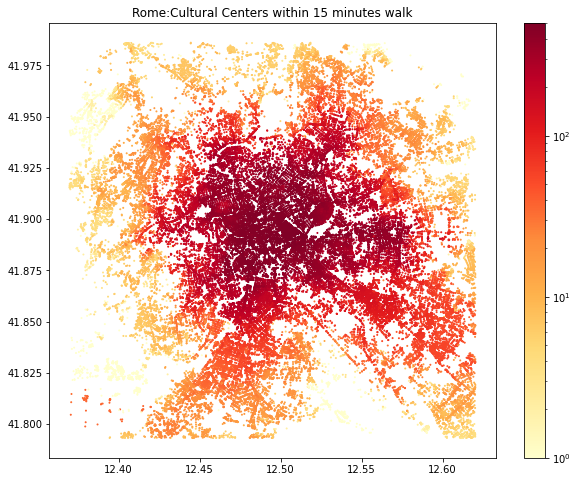

count    51322.000000
mean       386.133120
std        203.207864
min          0.000000
25%        196.000000
50%        449.000000
75%        574.000000
max        651.000000
dtype: float64


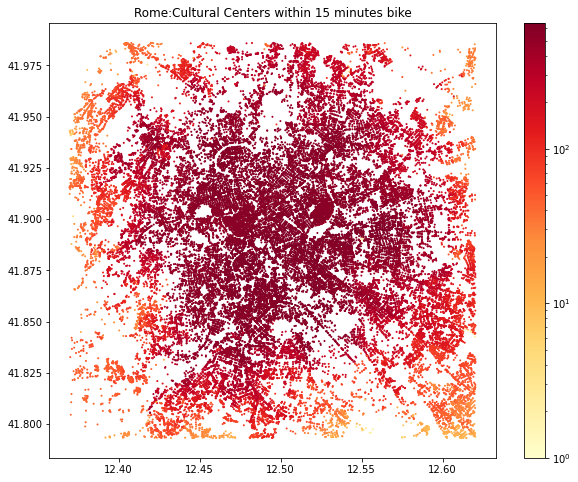

In [56]:
for mode in networks:
    access_analysis(network=networks[mode], df=cultural_centers, lat_col_name='lat', lon_col_name='lng', 
                    name='Cultural Centers',
                   mode_name=mode, plot=True, save_gdf=True)

## Green Areas

count    71240.000000
mean      5843.474495
std       4697.981693
min          0.000000
25%       1473.750000
50%       5308.000000
75%       9146.000000
max      16039.000000
dtype: float64


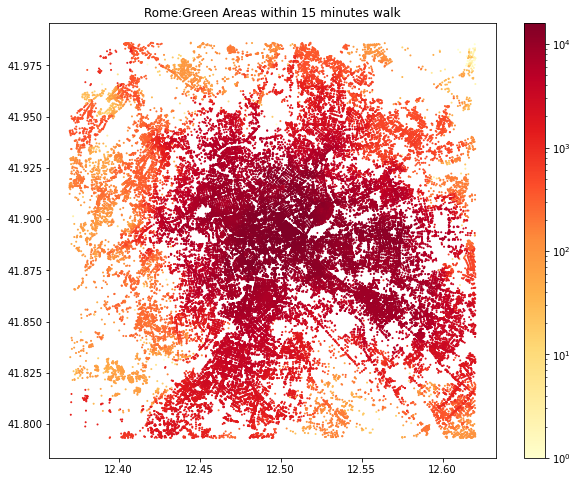

count    51322.000000
mean     13244.337652
std       6527.018355
min          0.000000
25%       8272.250000
50%      13939.500000
75%      19162.000000
max      23468.000000
dtype: float64


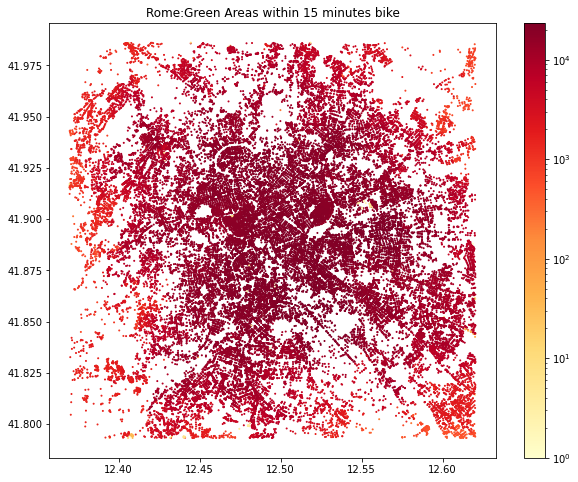

In [57]:
for mode in networks:
    access_analysis(network=networks[mode], df=green, lat_col_name='lat', lon_col_name='lng', 
                    name='Green Areas',
                   mode_name=mode, plot=True, save_gdf=True)

## Historical

count    71240.000000
mean       377.165328
std        385.397251
min          0.000000
25%         18.000000
50%        199.000000
75%        768.000000
max       1069.000000
dtype: float64


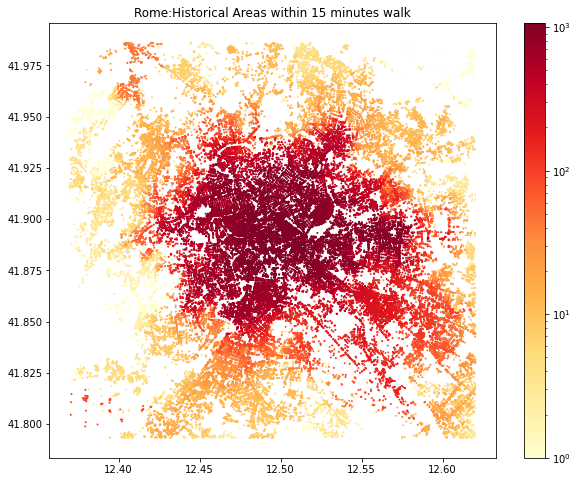

count    51322.000000
mean       796.491407
std        428.783295
min          0.000000
25%        408.000000
50%        968.000000
75%       1166.000000
max       1301.000000
dtype: float64


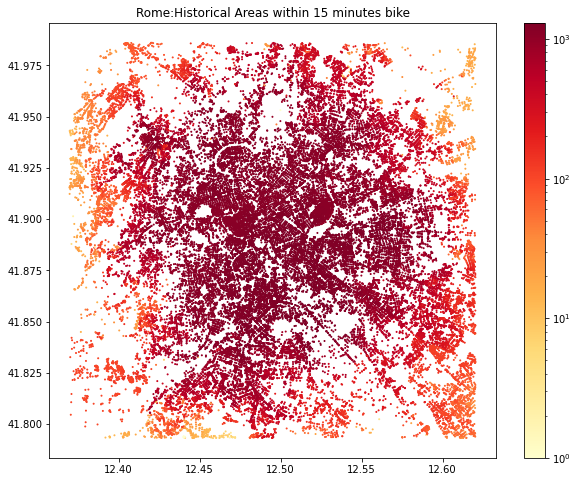

In [58]:
for mode in networks:
    access_analysis(network=networks[mode], df=historical, lat_col_name='lat', lon_col_name='lng', 
                    name='Historical Areas',
                   mode_name=mode, plot=True, save_gdf=True)

## Museums

count    71240.000000
mean        38.124256
std         40.833917
min          0.000000
25%          1.000000
50%         12.000000
75%         79.000000
max        110.000000
dtype: float64


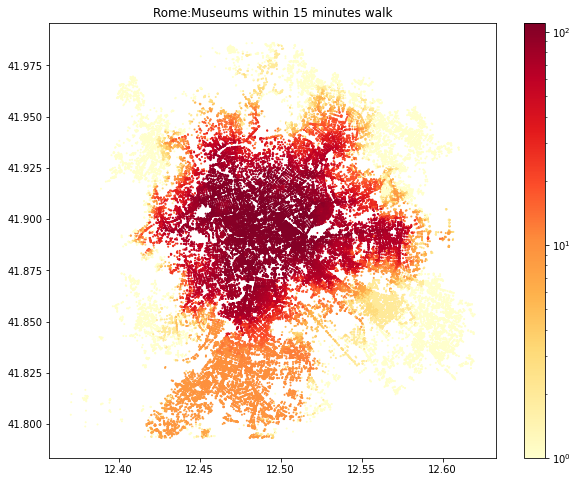

count    51322.000000
mean        79.738494
std         47.053315
min          0.000000
25%         32.000000
50%        103.000000
75%        122.000000
max        128.000000
dtype: float64


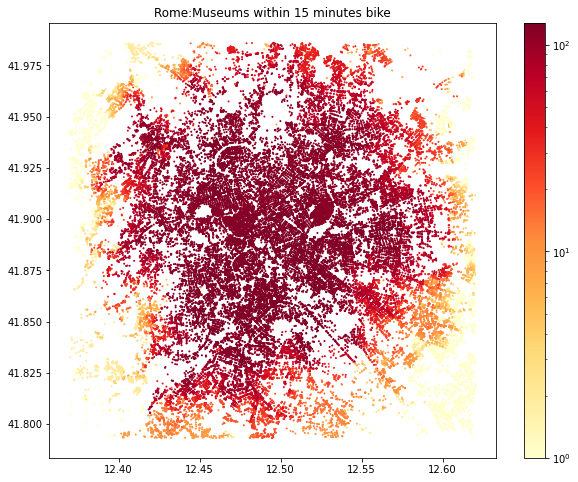

In [59]:
for mode in networks:
    access_analysis(network=networks[mode], df=museums, lat_col_name='lat', lon_col_name='lng', 
                    name='Museums',
                   mode_name=mode, plot=True, save_gdf=True)

# Get average by H3 cell

In [60]:
for mode in ['walk', 'bike']:
    avg_by_h3=networks[mode].nodes_df.groupby('h3').agg(
        {col: 'mean' for col in networks[mode].nodes_df.columns if 'access' in col})
    avg_by_h3.to_csv('outputs/access/{}_access_by_h3.csv'.format(mode))